In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iisignature
import torch
from scipy.integrate import quad
import cmath
from py_vollib.ref_python.black_scholes_merton.implied_volatility import implied_volatility
import matplotlib.cm as cm
from functools import partial
from scipy.optimize import least_squares
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
from scipy.optimize import minimize_scalar
from scipy.optimize import differential_evolution
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import least_squares
from matplotlib.patches import Patch

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
def sim_t_Wt(T=1, N=100, d=2, rho=-0.3):
    dt = T / N
    t = np.linspace(0, T, N + 1).reshape(-1, 1)  # Column vector of time steps
    
    # Construct the correlation matrix
    corr_matrix = (1 - rho) * np.eye(d) + rho * np.ones((d, d))
    L = np.linalg.cholesky(corr_matrix)  # Cholesky decomposition
    
    dW = np.random.randn(N, d) * np.sqrt(dt)  # Independent Brownian increments
    dW = dW @ L.T  # Introduce correlation
    
    W = np.cumsum(dW, axis=0)  # Compute Brownian motion
    W = np.vstack([np.zeros((1, d)), W])  # Start at zero
    
    return np.hstack([t, W])  # Combine (t, W_t) as a single array
def compute_signature(path, order):
    return iisignature.sig(path, order)


def generate_paths(T, N, d, num_simulations):
    #T = Max_Maturity
    #N = Number of time steps for each year
    #d = Dimension of Brownian_Motion + timesteps
    #n = Number of simulations
    
    time_steps=int(N*T)
    all_brownian_motions = np.zeros((num_simulations, d, time_steps + 1))

    for sim in range(num_simulations):
        if sim % (num_simulations // 10) == 0:  # Print progress at intervals
            print(f"Progress: {sim / num_simulations:.1%}")

        W = sim_t_Wt(T, time_steps, d-1)  # Generate correlated Brownian paths
        all_brownian_motions[sim] = W.T  # Transpose to match expected shape
    
    return all_brownian_motions

def implied_vol_minimize( price, S0, K, T, r, payoff="call", disp=True ):
    """ Returns Implied volatility by minimization"""
    
    n = 2     # must be even
    def obj_fun(vol):
        return ( BlackScholes(True, S0, K, T, r, 0., vol) - price)**n
        
    res = minimize_scalar( obj_fun, bounds=(1e-15, 8), method='bounded')
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return -1

def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag,np.exp(-r*T),np.exp((r-d)*T)*S,X,T,v)

def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    


This code retrieves and visualizes the implied volatility smiles for S&P 500 index options across multiple maturities using data from Yahoo Finance.

This plots correspond to a calibration obtained in date 28 of march 2025. 


We target option maturities going from 3 moths to 21 months

We consider as a strike range for the cosidered options: 90% to 130% of the current S&P 500 spot price.  

We remove some data which consitute clear outliers.



Selected Expiration Dates: ['2025-06-20', '2025-09-19', '2025-12-19', '2026-03-20', '2026-06-18', '2026-12-18']


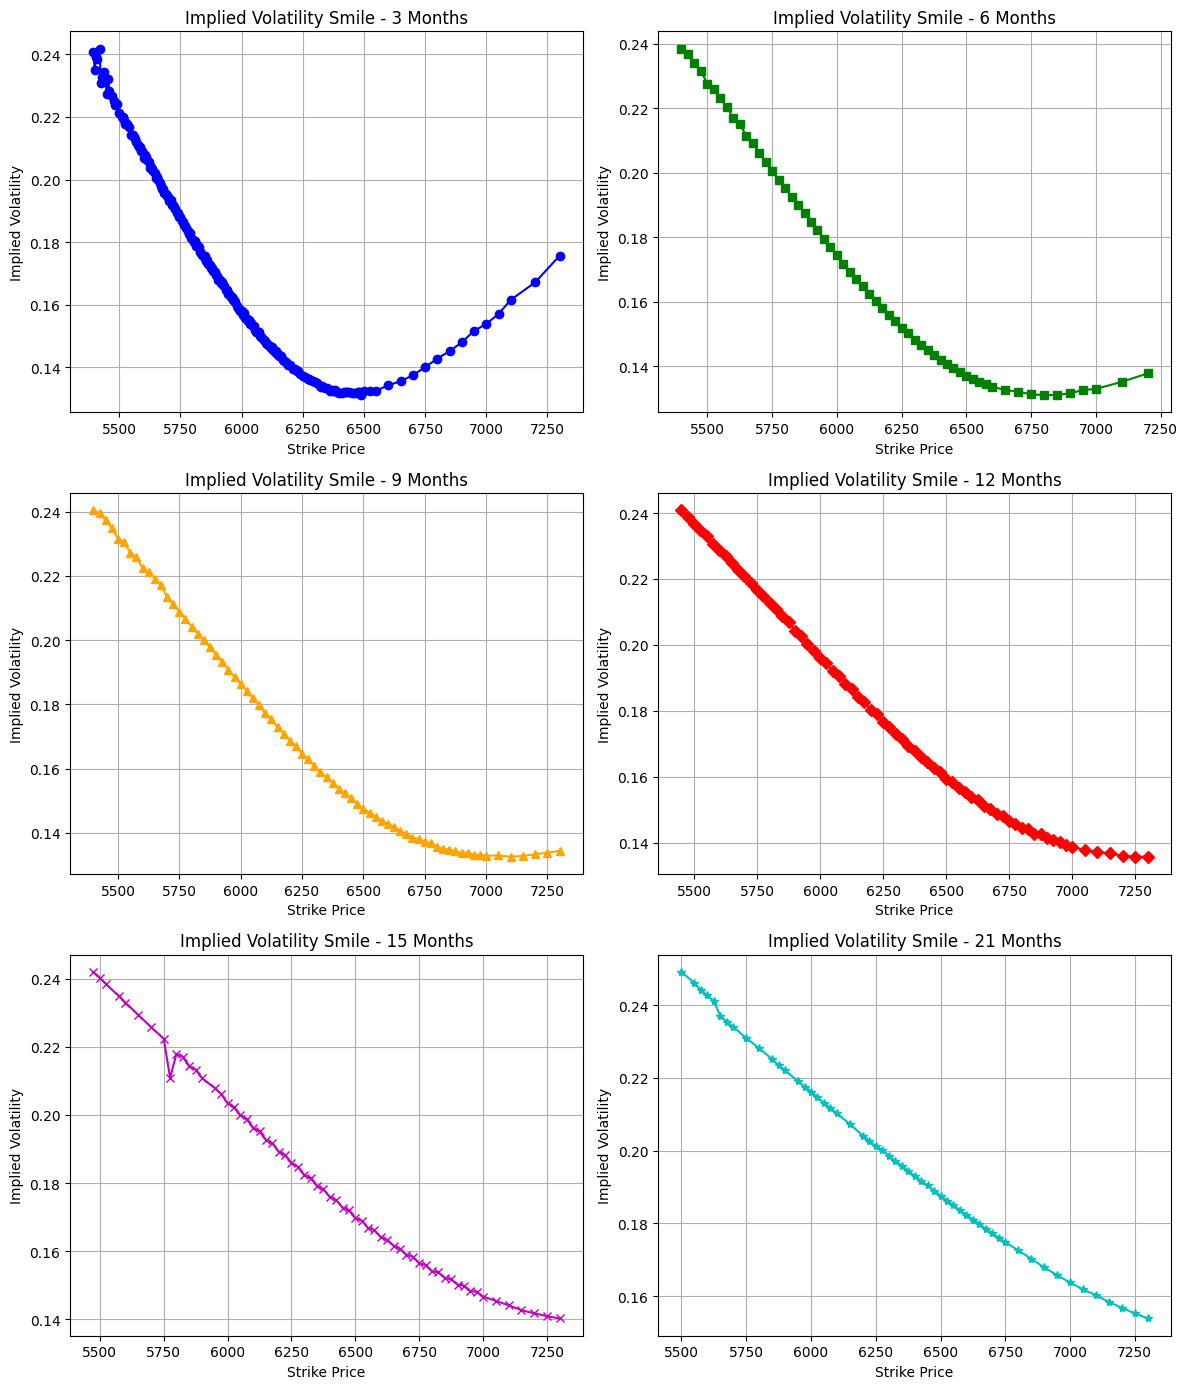

In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define target maturities
target_maturities = [3, 6, 9, 12, 15, 21]  # in months

# Define the ticker for S&P 500 index options
ticker = "^SPX"
spx = yf.Ticker(ticker)

# Get all available expiration dates from Yahoo Finance
expirations = [datetime.strptime(date, "%Y-%m-%d") for date in spx.options]

# Get today's date
today = datetime.today()

# Find the closest expiration dates to the target maturities
selected_expirations = []
for months in target_maturities:
    target_date = today + timedelta(days=months * 30)  # Approximate months as 30 days
    closest_date = min(expirations, key=lambda x: abs(x - target_date))
    selected_expirations.append(closest_date.strftime("%Y-%m-%d"))  # Store as string

print("Selected Expiration Dates:", selected_expirations)

# Initialize an empty list to store option data
options_data = []

for exp_date in selected_expirations:
    # Fetch option chain for the expiration date
    opt_chain = spx.option_chain(exp_date)
    
    # Extract call options
    calls = opt_chain.calls.copy()
    
    # Add expiration date as a column
    calls["expiration"] = exp_date  
    
    # Append to list
    options_data.append(calls)

# Combine all option data into a single DataFrame
options_df = pd.concat(options_data, ignore_index=True)

# Select relevant columns
options_df = options_df[["strike", "lastPrice", "bid", "ask", "volume", "openInterest", "impliedVolatility", "expiration"]]

# Get the current S&P 500 spot price
spx_spot_price = spx.history(period="1d")["Close"].iloc[-1]

# Define strike range (0.95 to 1.3 of spot price)
strike_min = 0.95 * spx_spot_price
strike_max = 1.3 * spx_spot_price

# Remove outliers: filter out options with IV > 0.3
options_df = options_df[options_df["impliedVolatility"] <= 0.25]

# Split into separate DataFrames for different maturities
df_3m = options_df[options_df["expiration"] == selected_expirations[0]]
df_6m = options_df[options_df["expiration"] == selected_expirations[1]]
df_9m = options_df[options_df["expiration"] == selected_expirations[2]]
df_12m = options_df[options_df["expiration"] == selected_expirations[3]]
df_15m = options_df[options_df["expiration"] == selected_expirations[4]]
df_21m = options_df[options_df["expiration"] == selected_expirations[5]]

# Filter dataframes for strikes within the range
df_3m_filtered = df_3m[(df_3m["strike"] >= strike_min) & (df_3m["strike"] <= strike_max)]
df_6m_filtered = df_6m[(df_6m["strike"] >= strike_min) & (df_6m["strike"] <= strike_max)]
df_9m_filtered = df_9m[(df_9m["strike"] >= strike_min) & (df_9m["strike"] <= strike_max)]
df_12m_filtered = df_12m[(df_12m["strike"] >= strike_min) & (df_12m["strike"] <= strike_max)]
df_15m_filtered = df_15m[(df_15m["strike"] >= strike_min) & (df_15m["strike"] <= strike_max)]
df_21m_filtered = df_21m[(df_21m["strike"] >= strike_min) & (df_21m["strike"] <= strike_max)]

# Plot implied volatility smiles in separate graphs
fig, axes = plt.subplots(3, 2, figsize=(12, 14))  # Adjust layout for 6 plots

# Define axes
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()  # Use all 6 axes

# Plot each maturity separately
ax1.plot(df_3m_filtered["strike"], df_3m_filtered["impliedVolatility"], marker='o', label="3 Months", color='b')
ax1.set_title("Implied Volatility Smile - 3 Months")
ax1.set_xlabel("Strike Price")
ax1.set_ylabel("Implied Volatility")
ax1.grid(True)

ax2.plot(df_6m_filtered["strike"], df_6m_filtered["impliedVolatility"], marker='s', label="6 Months", color='g')
ax2.set_title("Implied Volatility Smile - 6 Months")
ax2.set_xlabel("Strike Price")
ax2.set_ylabel("Implied Volatility")
ax2.grid(True)

ax3.plot(df_9m_filtered["strike"], df_9m_filtered["impliedVolatility"], marker='^', label="9 Months", color='orange')
ax3.set_title("Implied Volatility Smile - 9 Months")
ax3.set_xlabel("Strike Price")
ax3.set_ylabel("Implied Volatility")
ax3.grid(True)

ax4.plot(df_12m_filtered["strike"], df_12m_filtered["impliedVolatility"], marker='D', label="12 Months", color='r')
ax4.set_title("Implied Volatility Smile - 12 Months")
ax4.set_xlabel("Strike Price")
ax4.set_ylabel("Implied Volatility")
ax4.grid(True)

ax5.plot(df_15m_filtered["strike"], df_15m_filtered["impliedVolatility"], marker='x', label="15 Months", color='m')
ax5.set_title("Implied Volatility Smile - 15 Months")
ax5.set_xlabel("Strike Price")
ax5.set_ylabel("Implied Volatility")
ax5.grid(True)

ax6.plot(df_21m_filtered["strike"], df_21m_filtered["impliedVolatility"], marker='*', label="21 Months", color='c')
ax6.set_title("Implied Volatility Smile - 21 Months")
ax6.set_xlabel("Strike Price")
ax6.set_ylabel("Implied Volatility")
ax6.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


In order to obtain a faster and more precise calibration, we select only a small portion (20) of strikes for each considered maturity.

If we did include all strikes the optimizer would take too long to converge.

In [4]:
import numpy as np

# Step 1: Find common strikes across all maturities
common_strikes = set(df_3m_filtered["strike"]).intersection(
    set(df_6m_filtered["strike"]),
    set(df_9m_filtered["strike"]),
    set(df_12m_filtered["strike"]),
    set(df_15m_filtered["strike"]),
    set(df_21m_filtered["strike"])
)

# Convert to a sorted list
common_strikes = sorted(list(common_strikes))

# Step 2: Select 20 equally spaced strikes based on index positions
if len(common_strikes) >= 20:
    indices = np.linspace(0, len(common_strikes) - 1, num=20, dtype=int)  # Select 20 index positions
    selected_common_strikes = [common_strikes[i] for i in indices]  # Pick corresponding strikes
else:
    selected_common_strikes = common_strikes  # If fewer than 20 exist, take all available

# Display the selected strikes
print("Selected 20 equispaced common strikes:", selected_common_strikes)


Selected 20 equispaced common strikes: [5500.0, 5600.0, 5700.0, 5800.0, 5900.0, 5975.0, 6025.0, 6075.0, 6200.0, 6250.0, 6300.0, 6350.0, 6425.0, 6475.0, 6525.0, 6600.0, 6750.0, 6850.0, 6950.0, 7200.0]


In [5]:
# Initialize lists to store implied volatilities for each maturity
iv_3m = []
iv_6m = []
iv_9m = []
iv_12m = []
iv_15m = []
iv_21m = []

# Loop through the selected common strikes and extract IVs from each DataFrame
for strike in selected_common_strikes:
    print(strike)  # Print selected strikes for debugging

    # Get implied volatility for each maturity, handling cases where the strike is missing
    iv_3m.append(df_3m_filtered.loc[df_3m_filtered["strike"] == strike, "impliedVolatility"].values[0] 
                 if not df_3m_filtered[df_3m_filtered["strike"] == strike].empty else np.nan)

    iv_6m.append(df_6m_filtered.loc[df_6m_filtered["strike"] == strike, "impliedVolatility"].values[0] 
                 if not df_6m_filtered[df_6m_filtered["strike"] == strike].empty else np.nan)

    iv_9m.append(df_9m_filtered.loc[df_9m_filtered["strike"] == strike, "impliedVolatility"].values[0] 
                 if not df_9m_filtered[df_9m_filtered["strike"] == strike].empty else np.nan)

    iv_12m.append(df_12m_filtered.loc[df_12m_filtered["strike"] == strike, "impliedVolatility"].values[0] 
                  if not df_12m_filtered[df_12m_filtered["strike"] == strike].empty else np.nan)

    iv_15m.append(df_15m_filtered.loc[df_15m_filtered["strike"] == strike, "impliedVolatility"].values[0] 
                  if not df_15m_filtered[df_15m_filtered["strike"] == strike].empty else np.nan)

    iv_21m.append(df_21m_filtered.loc[df_21m_filtered["strike"] == strike, "impliedVolatility"].values[0] 
                  if not df_21m_filtered[df_21m_filtered["strike"] == strike].empty else np.nan)

# Print the lists of implied volatilities
print("\nIV for 3M Maturity:", iv_3m)
print("\nIV for 6M Maturity:", iv_6m)
print("\nIV for 9M Maturity:", iv_9m)
print("\nIV for 12M Maturity:", iv_12m)
print("\nIV for 15M Maturity:", iv_15m)
print("\nIV for 21M Maturity:", iv_21m)

# Store all IV lists in a single list
iv_tot = [iv_3m, iv_6m, iv_9m, iv_12m, iv_15m, iv_21m]

# Flatten the IV list
iv_flat = []
for iv_list in iv_tot:
    iv_flat.extend(iv_list)

# Normalize strikes by the spot price
Strikes = [strk / spx_spot_price for strk in selected_common_strikes]

# Convert maturities to years
Maturities = [mat / 12 for mat in target_maturities]


5500.0
5600.0
5700.0
5800.0
5900.0
5975.0
6025.0
6075.0
6200.0
6250.0
6300.0
6350.0
6425.0
6475.0
6525.0
6600.0
6750.0
6850.0
6950.0
7200.0

IV for 3M Maturity: [0.22114578910827634, 0.20703441136360165, 0.19442696297645568, 0.1808038615989685, 0.1691634292984009, 0.16086654571533204, 0.1547764424324036, 0.1499737866020203, 0.14074803352355958, 0.13726524974823, 0.13526255371093754, 0.13328656028747557, 0.1321421625518799, 0.13196668823242189, 0.13224134368896484, 0.13422496643066406, 0.1399622137451172, 0.14508911560058596, 0.15158929473876953, 0.1671225866699219]

IV for 6M Maturity: [0.22757921171188353, 0.21683522430419921, 0.20612270783424375, 0.19538921073913576, 0.18473009949684144, 0.17699492446899412, 0.17180317340850831, 0.166927085390091, 0.15591321084976195, 0.1519555020141602, 0.14829533658981323, 0.14495369520187376, 0.14067174034118654, 0.13813308469772337, 0.13604646615982058, 0.13359554767608645, 0.13129530822753904, 0.13108931663513182, 0.1326075509643555, 0.137795487

Now here we can plot the new implied volatility smiles on top of which we will actually perform the calibration for our model.

We clearly see that the 3 month smile exhibits a very different behaviour compared to the other for out of the money call options. This is a classic occurance of observed real option price data.



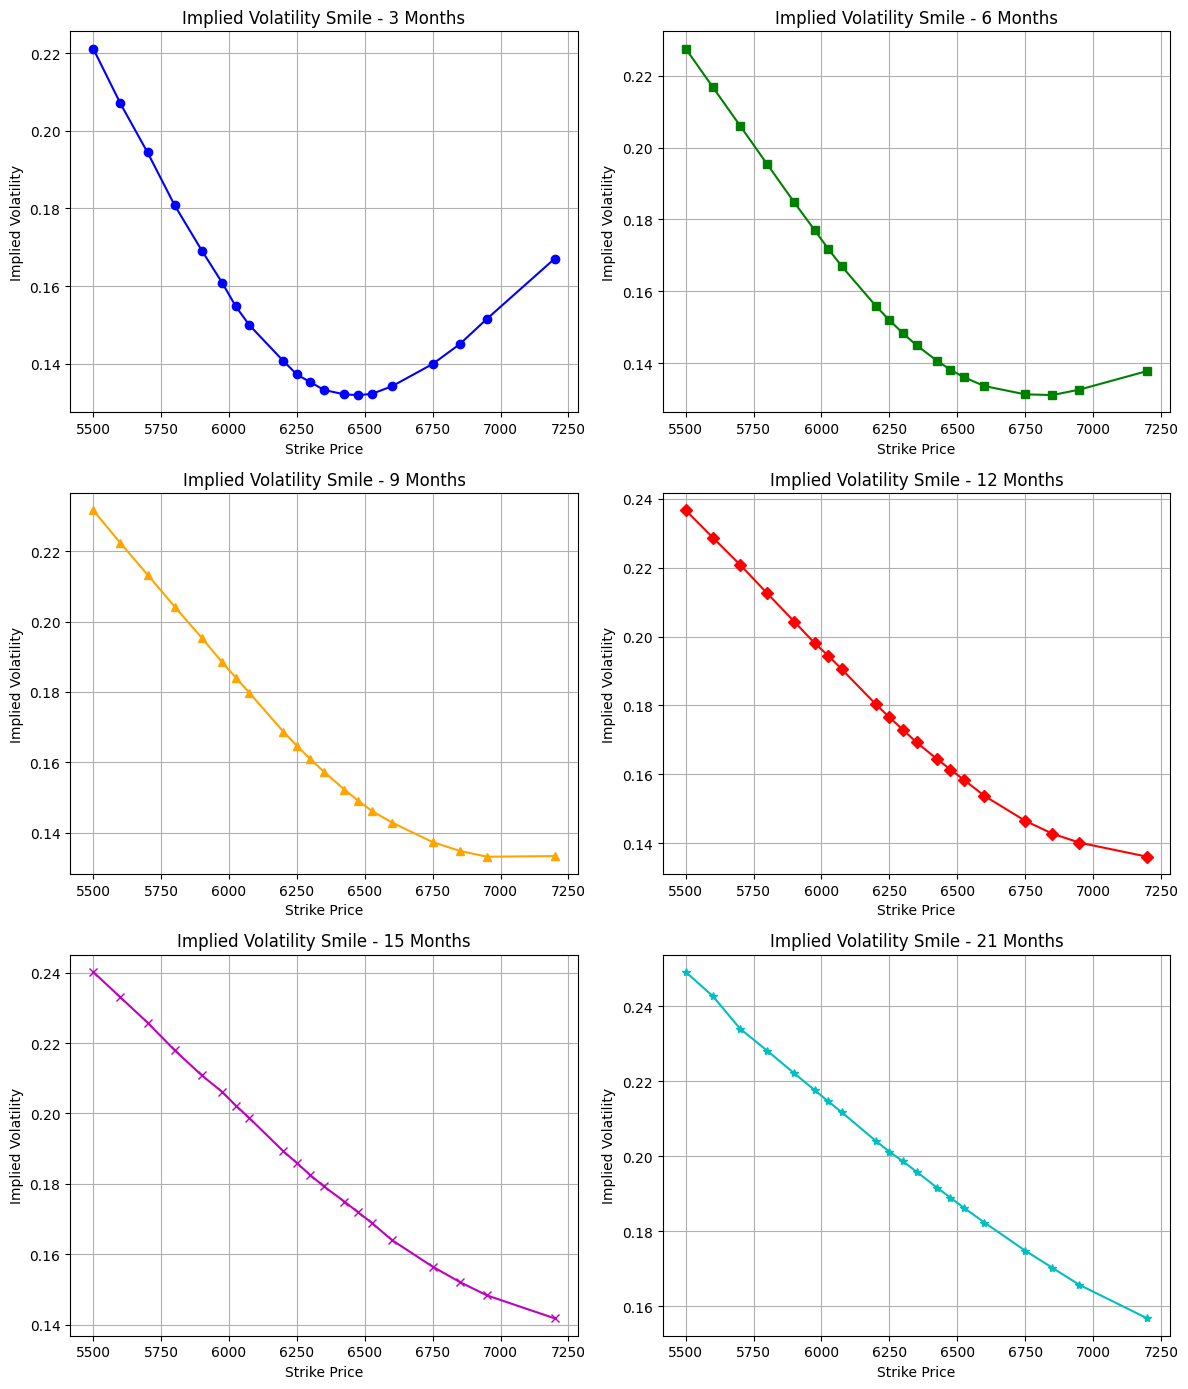

In [6]:
import matplotlib.pyplot as plt

# Create a figure with 3x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 14))

# Define individual axes
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

# Plot for 3M maturity
ax1.plot(selected_common_strikes, iv_3m, marker='o', linestyle='-', color='b')
ax1.set_title("Implied Volatility Smile - 3 Months")
ax1.set_xlabel("Strike Price")
ax1.set_ylabel("Implied Volatility")
ax1.grid(True)

# Plot for 6M maturity
ax2.plot(selected_common_strikes, iv_6m, marker='s', linestyle='-', color='g')
ax2.set_title("Implied Volatility Smile - 6 Months")
ax2.set_xlabel("Strike Price")
ax2.set_ylabel("Implied Volatility")
ax2.grid(True)

# Plot for 9M maturity
ax3.plot(selected_common_strikes, iv_9m, marker='^', linestyle='-', color='orange')
ax3.set_title("Implied Volatility Smile - 9 Months")
ax3.set_xlabel("Strike Price")
ax3.set_ylabel("Implied Volatility")
ax3.grid(True)

# Plot for 12M maturity
ax4.plot(selected_common_strikes, iv_12m, marker='D', linestyle='-', color='r')
ax4.set_title("Implied Volatility Smile - 12 Months")
ax4.set_xlabel("Strike Price")
ax4.set_ylabel("Implied Volatility")
ax4.grid(True)

# Plot for 15M maturity
ax5.plot(selected_common_strikes, iv_15m, marker='x', linestyle='-', color='m')
ax5.set_title("Implied Volatility Smile - 15 Months")
ax5.set_xlabel("Strike Price")
ax5.set_ylabel("Implied Volatility")
ax5.grid(True)

# Plot for 21M maturity
ax6.plot(selected_common_strikes, iv_21m, marker='*', linestyle='-', color='c')
ax6.set_title("Implied Volatility Smile - 21 Months")
ax6.set_xlabel("Strike Price")
ax6.set_ylabel("Implied Volatility")
ax6.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


In [7]:
N=100
d=3
num_simulations = 100000
Num_Maturities  = 6

m=4

BM_Paths=generate_paths(Maturities[-1], N, d, num_simulations)
signatures=np.zeros((num_simulations,Num_Maturities,iisignature.siglength(d, m)))
for i in range (num_simulations):
    for j,maturity in enumerate(Maturities):
        signatures[i,j,:]=compute_signature(BM_Paths[i,:,:int(maturity*N)].T, m)

Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%


In [8]:
# Global list to track errors
error_history = []


def obj_function(l, signatures, iv_flat, x, r, Strikes, Maturities):
    global latest_l, error_history  # Declare that we are modifying the global variable
    latest_l = l  # Update the global variable with the current l

    Computed_Ivs = []
    for j, maturity in enumerate(Maturities):
        S_T = x + l.T @ signatures[:, j, :].T
        for strike in Strikes:
            Computed_Ivs.append(implied_vol_minimize(np.mean(np.maximum(S_T - strike, 0)) * np.exp(-r * maturity), x, strike, maturity, r, "call"))

    Computed_Ivs = np.array(Computed_Ivs)
    error = Computed_Ivs - iv_flat

    total_error = np.sum(error ** 2)
    
    # Store error for tracking
    error_history.append(total_error)
    
    # Clear previous output
    clear_output(wait=True)
    
    # Print current iteration, error, and l values
    print(f"Iteration: {len(error_history)}")
    print(f"Current Error: {total_error:.6f}")
    print(f"Current l:\n{l}")
    print(f"error:\n{error}")

    return total_error


In [15]:
l_initial = np.ones(iisignature.siglength(d, m))*0.01

x=1
r=0
res = least_squares(obj_function, l_initial, args=(signatures, iv_flat,x,r, Strikes, Maturities),
                    loss="linear",  # Linear least squares loss
                    ftol=1e-4, xtol=1e-4, gtol=1e-4)

l_optimized=res.x

Iteration: 50694
Current Error: 0.004387
Current l:
[ 0.06276557  0.10235586  0.11249701 -0.01572576 -0.01467506  0.00311044
 -0.01440642  0.03905748 -0.01228783  0.00229086 -0.01438053  0.01930715
  0.00395881 -0.0051299   0.0081032  -0.00529644 -0.01323453  0.0022014
  0.00811988  0.00150392 -0.01778933 -0.00478698  0.00120742 -0.00287745
 -0.01300458 -0.01297858  0.01094254  0.00252132  0.01418763  0.00131745
  0.00756764 -0.00324108 -0.00359623  0.00084108  0.00965071  0.01277196
 -0.01816896  0.00077092 -0.01459564  0.01188412  0.0052554   0.01159981
  0.00519268  0.00345787  0.00695973  0.0116166   0.00669413  0.00211433
  0.00520655  0.00728891  0.00532017  0.00339616 -0.00721058  0.01008286
  0.00699331  0.01358436  0.00076317  0.01158791  0.00524501  0.00598688
  0.00662019  0.00960574  0.00921802  0.00232004  0.00096002  0.00162063
  0.00547342  0.00823012  0.00469234  0.00725233 -0.00025204  0.01038004
  0.00557546  0.01078806  0.00179565  0.00345966 -0.00044971  0.00835781


In [17]:
Computed_Ivs = []
temp=[]
Computed_Ivs_Separated=[]

for j, maturity in enumerate(Maturities):
    S_T = x + l_optimized.T @ signatures[:, j, :].T
    for strike in Strikes:
        Computed_Ivs.append(implied_vol_minimize(np.mean(np.maximum(S_T - strike, 0)) * np.exp(-r * maturity), x, strike, maturity, r, "call"))
        temp.append(Computed_Ivs[-1])
    Computed_Ivs_Separated.append(temp)
    temp=[]
Computed_Ivs=np.array(Computed_Ivs)  

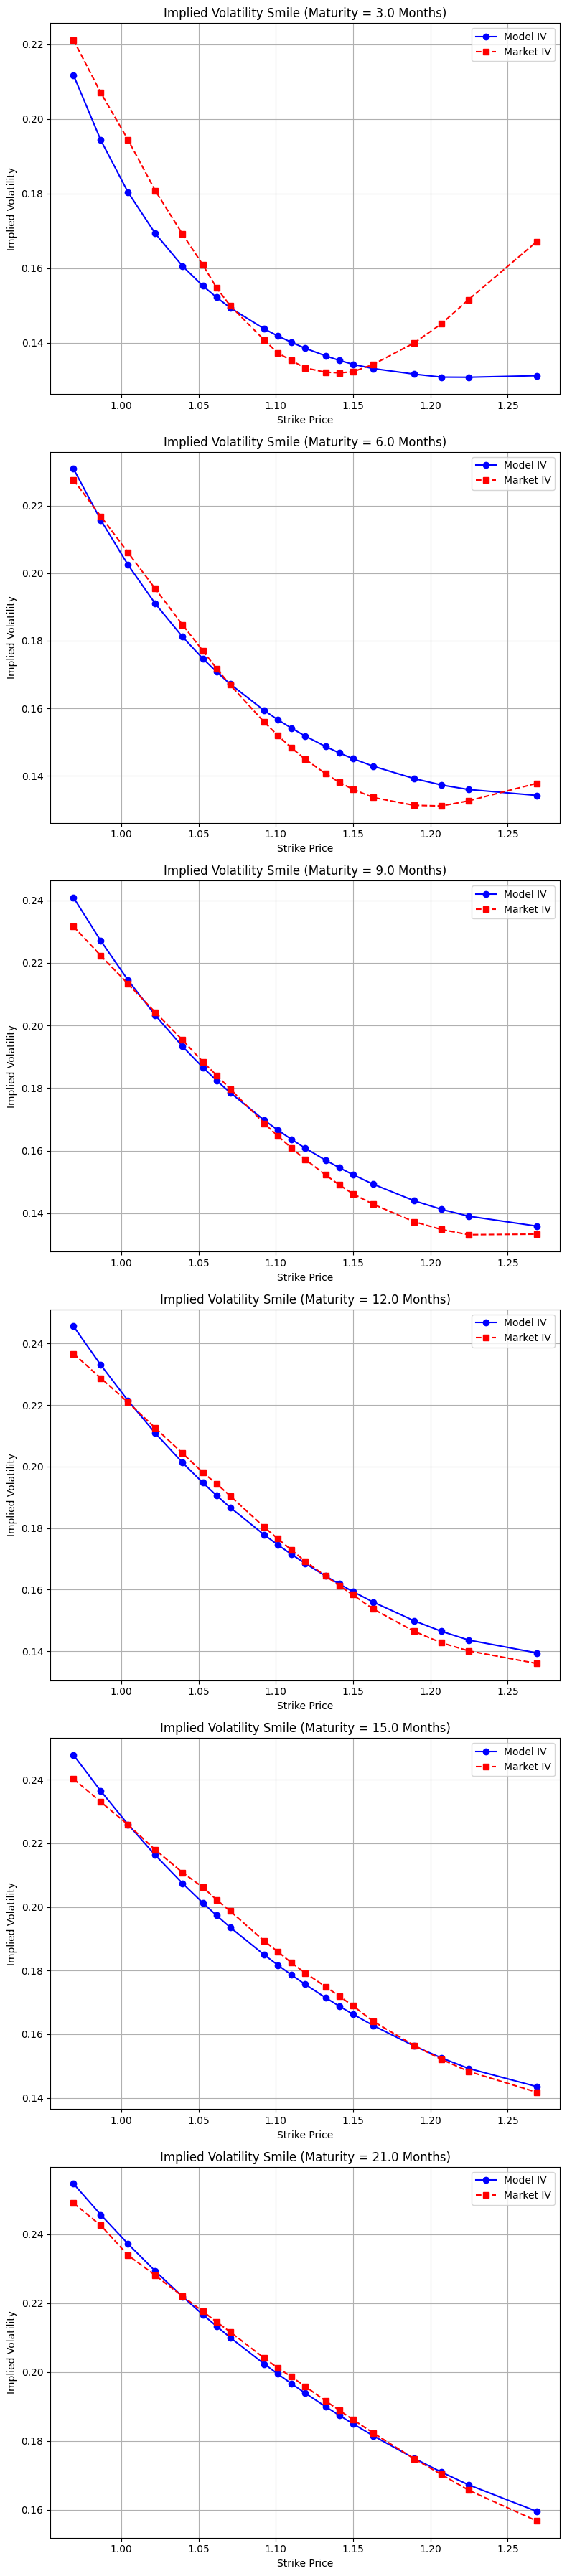

In [18]:
fig, axes = plt.subplots(len(Maturities), 1, figsize=(8, 6 * len(Maturities)))


for i, maturity in enumerate(Maturities):
    ax = axes[i]  # Select the subplot

    ax.plot(Strikes, Computed_Ivs_Separated[i], marker="o", linestyle="-", label="Model IV", color="blue")
    ax.plot(Strikes, iv_tot[i], marker="s", linestyle="--", label="Market IV", color="red")

    ax.set_title(f"Implied Volatility Smile (Maturity = {maturity*12} Months)")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Implied Volatility")
    ax.legend()
    ax.grid()


# Adjust layout for better visibility
plt.tight_layout()
plt.show()


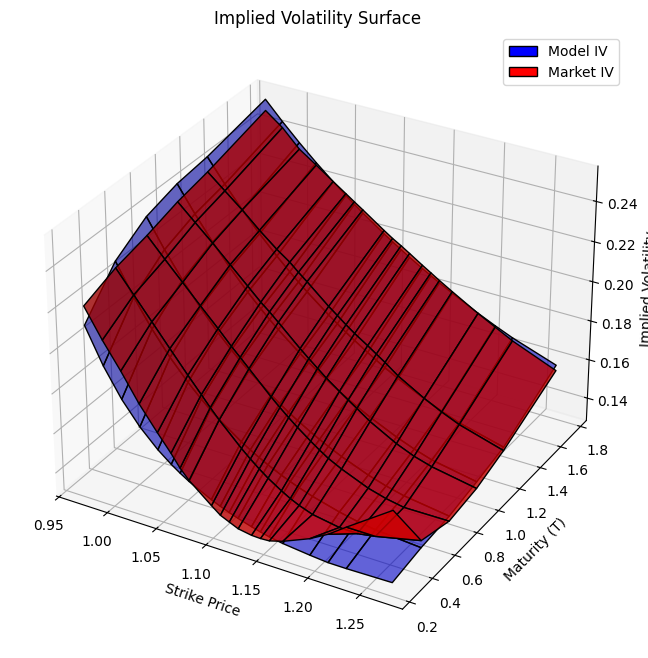

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

# Convert lists to arrays for plotting
iv_call2 = np.array(iv_tot)
model_iv2 = np.array(Computed_Ivs_Separated)  # Ensure model IV data is also a NumPy array

# Create a meshgrid for 3D plotting
Strikes_grid, Maturities_grid = np.meshgrid(Strikes, Maturities)

# Create figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Market IV surface (Solid Red)
market_surface = ax.plot_surface(Strikes_grid, Maturities_grid, iv_call2, color='red', edgecolor='k', alpha=0.8)

# Plot Model IV surface (Solid Blue)
model_surface = ax.plot_surface(Strikes_grid, Maturities_grid, model_iv2, color='blue', edgecolor='k', alpha=0.6)

# Labels and title
ax.set_xlabel("Strike Price")
ax.set_ylabel("Maturity (T)")
ax.set_zlabel("Implied Volatility")
ax.set_title("Implied Volatility Surface")

# Create a custom legend using proxy artists
legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label="Model IV"),
    Patch(facecolor='red', edgecolor='black', label="Market IV")
]

# Add the legend
ax.legend(handles=legend_elements, loc='upper right')

# Show the plot
plt.show()


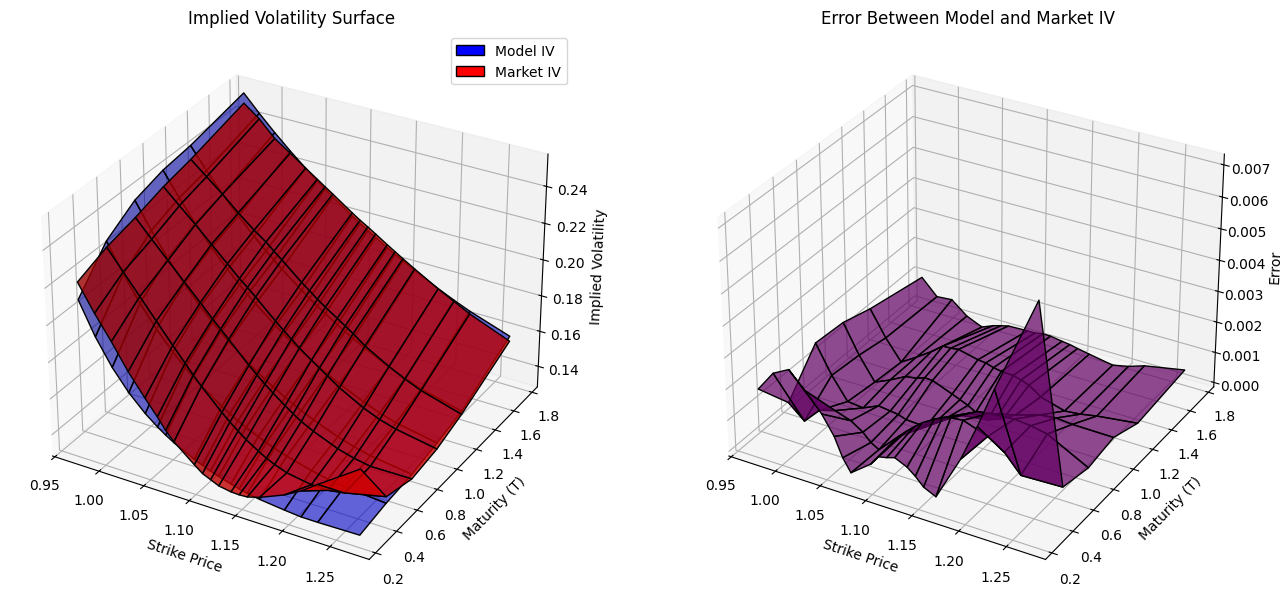

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

# Convert lists to arrays for plotting
iv_tot2 = np.array(iv_tot)
model_iv2 = np.array(Computed_Ivs_Separated)

# Compute the absolute error
error_iv = np.abs(model_iv2 - iv_call2)

# Create a meshgrid for 3D plotting
Strikes_grid, Maturities_grid = np.meshgrid(Strikes, Maturities)

# Create figure and subplots
fig = plt.figure(figsize=(16, 8))  # Wider figure for side-by-side subplots

# ---- Left subplot: 3D IV Surface ----
ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 cols, first subplot
ax1.plot_surface(Strikes_grid, Maturities_grid, iv_call2, color='red', edgecolor='k', alpha=0.8)
ax1.plot_surface(Strikes_grid, Maturities_grid, model_iv2, color='blue', edgecolor='k', alpha=0.6)

# Labels and title
ax1.set_xlabel("Strike Price")
ax1.set_ylabel("Maturity (T)")
ax1.set_zlabel("Implied Volatility")
ax1.set_title("Implied Volatility Surface")

# Custom legend
legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label="Model IV"),
    Patch(facecolor='red', edgecolor='black', label="Market IV")
]
ax1.legend(handles=legend_elements, loc='upper right')

# ---- Right subplot: Error plot ----
ax2 = fig.add_subplot(122, projection='3d')  # 1 row, 2 cols, second subplot
error_surface = ax2.plot_surface(Strikes_grid, Maturities_grid, error_iv/5, color='purple', edgecolor='k', alpha=0.7)

# Labels and title
ax2.set_xlabel("Strike Price")
ax2.set_ylabel("Maturity (T)")
ax2.set_zlabel("Error")
ax2.set_title("Error Between Model and Market IV")

# Show the figure
plt.show()
